In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
train = pd.read_csv('SpotifyAudioFeaturesNov2018.csv')
test = pd.read_csv('SpotifyAudioFeaturesApril2019.csv')

In [3]:
train.head()

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.005820,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,44
1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.024400,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,10
2,R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.025000,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,63
3,Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,0.029400,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,9
4,Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,0.000035,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,8


In [4]:
train.drop(['artist_name', 'track_id', 'track_name'], inplace=True, axis=1)
test.drop(['artist_name', 'track_id', 'track_name'], inplace=True, axis=1)

In [5]:
train.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,0.005820,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,44
1,0.024400,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,10
2,0.025000,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,63
3,0.029400,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,9
4,0.000035,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,8


In [6]:
train = train.sample(10000, axis=0)
test = test.sample(10000, axis=0)
train.shape

(10000, 14)

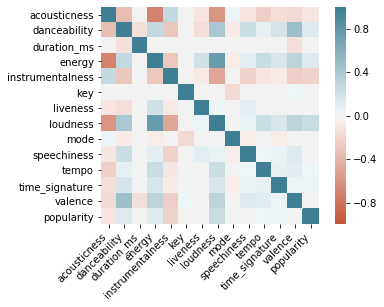

In [7]:
corr = train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [10]:
X_train = train.iloc[:, 0:13]
y_train = train.iloc[:, 13]
X_test = test.iloc[:, 0:13]
y_test = test.iloc[:, 13]

In [11]:
key = pd.get_dummies(X_train['key'], prefix='key')
time_signature = pd.get_dummies(X_train['time_signature'], prefix='time_signature')
X_train = pd.concat([X_train, key, time_signature], axis=1)
X_train.drop(['key', 'time_signature'], inplace=True, axis=1)

key = pd.get_dummies(X_test['key'], prefix='key')
time_signature = pd.get_dummies(X_test['time_signature'], prefix='time_signature')
X_test = pd.concat([X_test, key, time_signature], axis=1)
X_test.drop(['key', 'time_signature'], inplace=True, axis=1)

In [12]:
X_train.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,...,key_7,key_8,key_9,key_10,key_11,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
1950,0.910000,0.664,123609,0.0755,0.000000,0.164,-19.836,1,0.0389,80.004,...,0,0,0,1,0,0,1,0,0,0
32572,0.000179,0.411,212627,0.8870,0.000218,0.088,-4.740,1,0.0875,128.253,...,0,0,0,0,0,0,0,0,1,0
28400,0.000645,0.482,237720,0.9910,0.000044,0.362,-2.606,1,0.1450,147.045,...,0,0,0,1,0,0,0,0,1,0
33880,0.934000,0.468,191309,0.1900,0.000014,0.203,-14.372,0,0.0310,140.837,...,0,0,1,0,0,0,0,0,1,0
56037,0.117000,0.610,210077,0.5630,0.000000,0.439,-6.911,0,0.2500,128.087,...,0,0,0,0,0,0,0,0,1,0


In [13]:
X_train.shape

(10000, 28)

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

bg = Pipeline([
    ('std', StandardScaler()),
    ('bg', BaggingClassifier(DecisionTreeClassifier(criterion='entropy'), n_jobs=-1, max_features=0.3, max_samples=0.3, n_estimators=300, oob_score=True))
])
bg.fit(X_train.astype(float), y_train)

Pipeline(memory=None,
     steps=[('std', StandardScaler(copy=True, with_mean=True, with_std=True)), ('bg', BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_spl...stimators=300, n_jobs=-1, oob_score=True,
         random_state=None, verbose=0, warm_start=False))])

In [ ]:
bg.score(X_test.astype(float), y_test)